In [4]:
import kagglehub
path = kagglehub.dataset_download("mfaisalqureshi/spam-email")

Using Colab cache for faster access to the 'spam-email' dataset.


In [5]:
import os

csv_path = os.listdir(path)[0]
full_csv_path = os.path.join(path, csv_path)

In [6]:
import pandas as pd

df = pd.read_csv(full_csv_path)
df.head() #show first five rows

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
df.shape #Check how many columns and rows

(5572, 2)

In [8]:
# check null value
df.isnull().sum()

,0
Category,0
Message,0


In [9]:
# check duplicate if have duplicates drop it
df.drop_duplicates(keep='first', inplace=True)
df.duplicated().sum()

np.int64(0)

In [10]:
#Rename columns name
df.rename(columns={'Category': 'target', 'Message': 'email'}, inplace=True)
df.head()

,target,email
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [11]:
#Dataset Info
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5157 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  5157 non-null   object
 1   email   5157 non-null   object
dtypes: object(2)
memory usage: 120.9+ KB


In [12]:
#Count ham and spam
df['target'].value_counts()

,count
target,
ham,4516
spam,641


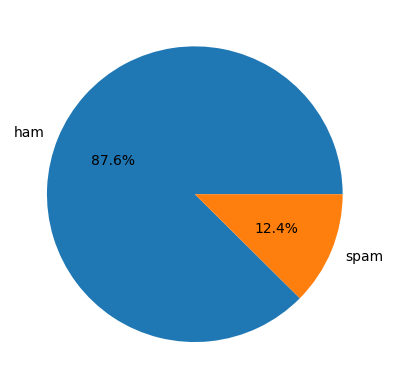

In [13]:
#Visualize Ham & Spam
import matplotlib.pyplot as plt

plt.pie(df['target'].value_counts(), labels=['ham', 'spam'], autopct='%1.1f%%')
plt.show()

In [14]:
# Encode the labels into numerical
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['target'] = le.fit_transform(df['target'])
df.head()

,target,email
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [15]:
#import stopwords
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

stop_words = stopwords.words('english')
ps = PorterStemmer()

In [16]:
def clean_emails(text: str) -> str:
  text: str = text.lower() #Lowecase
  text: str = re.sub(r'<.*?>', '', text) #remove html tags
  text: str = re.sub(r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', '', text) #remove emails
  text: str = re.sub(r'https?://\S+|www\.\S+', '', text) #remove urls
  text: str = re.sub(r'\+?\d{1,4}?[-.\s]?\(?\d{1,3}?\)?[-.\s]?\d{1,4}[-.\s]?\d{1,4}[-.\s]?\d{1,9}', '', text) #remove phone numbers
  text: list = nltk.word_tokenize(text) #tokenize the text
  text: list = [word for word in text if word not in stop_words] #remove stopwords
  text: list = [word for word in text if word not in string.punctuation] #remove punctuation
  text: list = [ps.stem(word) for word in text] #stem words

  text: str = ' '.join(text) #join the text
  return text

In [17]:
df['clean_emails'] = df['email'].apply(clean_emails)
df.head()

,target,email,clean_emails
0,0,"Go until jurong point, crazy.. Available only ...",go jurong point crazi .. avail bugi n great wo...
1,0,Ok lar... Joking wif u oni...,ok lar ... joke wif u oni ...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,u dun say earli hor ... u c alreadi say ...
4,0,"Nah I don't think he goes to usf, he lives aro...",nah n't think goe usf live around though


In [25]:
# Model Building
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

def train_evaluate_classifier(model, x, y):
  # Train-Test Split
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)
  # Train Model
  model.fit(x_train, y_train)
  # Predictions
  y_pred = model.predict(x_test)
  # Evaluation
  accuracy = accuracy_score(y_test, y_pred)
  # Print Results
  report = classification_report(y_test, y_pred, target_names=["Ham", "Spam"])
  print("Model Accuracy:", round(accuracy * 100, 2), "%\n")
  print("Classification Report:\n", report)
  # Human-Readable Explanation
  explanation = (
        f"The spam detection model achieved an accuracy of {round(accuracy * 100, 2)}%, "
        "which means it correctly classified most of the emails as spam or ham. \n"
        " The precision and recall values show that the model is very effective at identifying "
        "ham emails with high accuracy,\n while also performing strongly in detecting spam emails "
        "Overall, the results indicate that the model is reliable and \n suitable for real-world "
        "email spam filtering applications."
    )

  print("Result Explanation:\n", explanation)

In [35]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

# Create model and vectorizer
pipeline_model = Pipeline([
    ('tfidf', TfidfVectorizer(
        preprocessor=clean_emails,
        max_features=2000,
        ngram_range=(1, 2),
        min_df=2
    )),
    ('nb', MultinomialNB())
])

# Call function
train_evaluate_classifier(
    pipeline_model,
    df['email'],
    df['target']
)

Model Accuracy: 97.77 %

Classification Report:
               precision    recall  f1-score   support

         Ham       0.98      1.00      0.99       904
        Spam       0.99      0.83      0.90       128

    accuracy                           0.98      1032
   macro avg       0.98      0.91      0.94      1032
weighted avg       0.98      0.98      0.98      1032

Result Explanation:
 The spam detection model achieved an accuracy of 97.77%, which means it correctly classified most of the emails as spam or ham. 
 The precision and recall values show that the model is very effective at identifying ham emails with high accuracy,
 while also performing strongly in detecting spam emails Overall, the results indicate that the model is reliable and 
 suitable for real-world email spam filtering applications.


In [36]:
#export model
import joblib

joblib.dump(pipeline_model, "model.joblib")

print("Model saved successfully")

Model saved successfully
